In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
df=pd.read_csv('sales_qty.csv',parse_dates=True,index_col='dates',dayfirst=True)
df.head()

,class1
dates,
2020-03-01,62
2020-03-08,87
2020-03-15,80
2020-03-22,70
2020-03-29,87


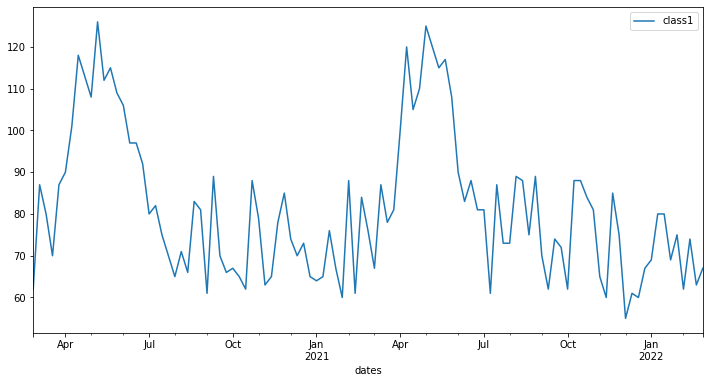

In [6]:
df.plot(figsize=(12,6))

In [94]:
train = df.iloc[:95]
test = df.iloc[95:]

In [95]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [96]:
scaler.fit(train)
train_sc = scaler.transform(train)
test_sc = scaler.transform(test)

In [97]:
from keras.preprocessing.sequence import TimeseriesGenerator
n_input = 7
n_features = 1
generator = TimeseriesGenerator(train_sc, train_sc, length=n_input, batch_size=1)

In [98]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [99]:
model = Sequential()
model.add(LSTM(100, activation='relu',return_sequences=True, input_shape=(n_input, n_features)))
model.add(LSTM(150, activation='relu',return_sequences=True))
model.add(LSTM(150, activation='relu',return_sequences=True))
model.add(LSTM(150, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [100]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 7, 100)            40800     
                                                                 
 lstm_18 (LSTM)              (None, 7, 150)            150600    
                                                                 
 lstm_19 (LSTM)              (None, 7, 150)            180600    
                                                                 
 lstm_20 (LSTM)              (None, 150)               180600    
                                                                 
 dense_5 (Dense)             (None, 1)                 151       
                                                                 
Total params: 552,751
Trainable params: 552,751
Non-trainable params: 0
_________________________________________________________________


In [101]:
model.fit(generator,epochs=300)

Epoch 1/300
88/88 [==============================] - 6s 20ms/step - loss: 0.0839
Epoch 2/300
88/88 [==============================] - 2s 21ms/step - loss: 0.0641
Epoch 3/300
88/88 [==============================] - 2s 21ms/step - loss: 0.0646
Epoch 4/300
88/88 [==============================] - 2s 21ms/step - loss: 0.0607
Epoch 5/300
88/88 [==============================] - 2s 21ms/step - loss: 0.0552
Epoch 6/300
88/88 [==============================] - 2s 21ms/step - loss: 0.0555
Epoch 7/300
88/88 [==============================] - 2s 21ms/step - loss: 0.0509
Epoch 8/300
88/88 [==============================] - 2s 21ms/step - loss: 0.0602
Epoch 9/300
88/88 [==============================] - 2s 21ms/step - loss: 0.0549
Epoch 10/300
88/88 [==============================] - 2s 21ms/step - loss: 0.0469
Epoch 11/300
88/88 [==============================] - 2s 21ms/step - loss: 0.0340
Epoch 12/300
88/88 [==============================] - 2s 22ms/step - loss: 0.0352
Epoch 13/300
88/88 [=====

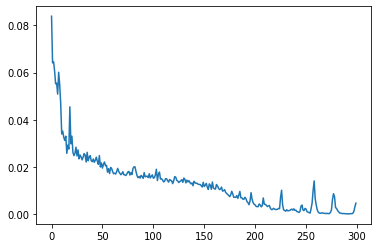

In [102]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [103]:
last_train_batch = train_sc[-7:]

In [104]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [105]:
model.predict(last_train_batch)

array([[0.49956015]], dtype=float32)

In [106]:
test_sc[0]

array([0.16901408])

In [107]:
test_predictions = []

first_eval_batch = train_sc[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [108]:
test_predictions

[array([0.49956015], dtype=float32),
 array([0.3270466], dtype=float32),
 array([0.18469274], dtype=float32),
 array([0.49757206], dtype=float32),
 array([0.4119783], dtype=float32),
 array([0.2568016], dtype=float32),
 array([0.35235795], dtype=float32),
 array([0.4357243], dtype=float32),
 array([0.38853696], dtype=float32),
 array([0.2552167], dtype=float32)]

In [109]:
true_predictions = scaler.inverse_transform(test_predictions)

In [110]:
test['Predictions'] = true_predictions[:]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [111]:
test.head()

,class1,Predictions
dates,,
2021-12-26,67,90.468770
2022-01-02,69,78.220309
2022-01-09,80,68.113185
2022-01-16,80,90.327617
2022-01-23,69,84.250460


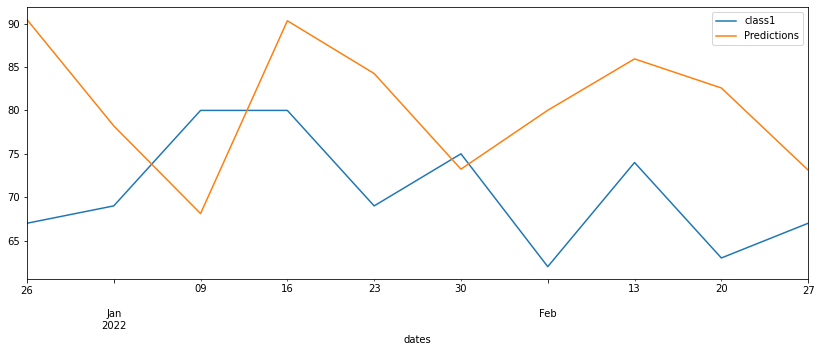

In [112]:
test.plot(figsize=(14,5))

In [113]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['class1'],test['Predictions']))
print(rmse)

14.16909760949843
